# Visual analysis

## Imports

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

## Variables

To speed up the analysis, you can skip displaying the images by setting the `SHOW_IMAGES` and `SHOW_FINAL_IMAGE` values to `False`. The final image will always be displayed.

In [2]:
SHOW_IMAGES = True
SHOW_FINAL_IMAGE = True

## Actual program

In the analysis, we use two water detection methods - NDWI (Normalized Difference Water Index) and MNDWI (Modified Normalized Difference Water Index). Both work in a similar way except that the MNDWI is more accurate in detecting water but also detects clouds. The modified NDWI (MNDWI) is shown here for illustrative purposes only - due to cloud detection, we do not use it later in the program.

### Opening files

In [3]:
filepath = 'node2/'

#### NDWI bands

In [4]:
band_green_10m = rasterio.open(filepath + 'B03.jpeg')
band_nir_10m = rasterio.open(filepath + 'B08.jpeg')

C:\Users\Szymon\AppData\Roaming\Python\Python310\site-packages\rasterio\__init__.py:318: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


#### MNDWI bands

In [5]:
band_green_20m = rasterio.open(filepath + 'B03.jpeg')
band_swir_20m = rasterio.open(filepath + 'B11.jpeg')

### Bands show

#### Green band (10m)

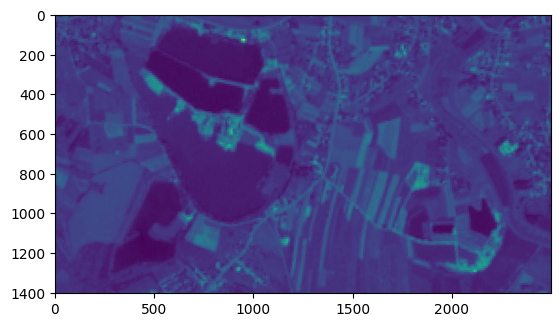

In [6]:
image_band_green_10m = band_green_10m.read(1)
if SHOW_IMAGES:
    plt.imshow(image_band_green_10m)

#### Near-infrared band (10m)

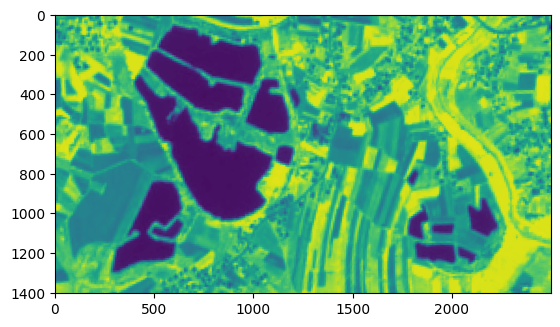

In [7]:
image_band_nir_10m = band_nir_10m.read(1)
if SHOW_IMAGES:
    plt.imshow(image_band_nir_10m)

#### Green band (20m)

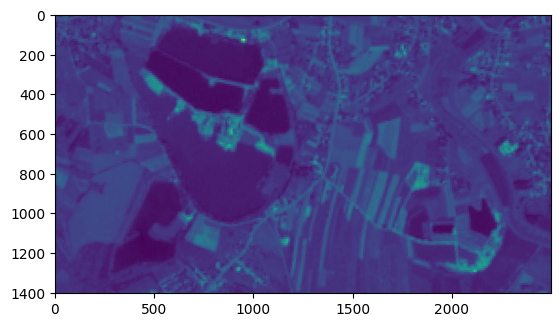

In [8]:
image_band_green_20m = band_green_20m.read(1)
if SHOW_IMAGES:
    plt.imshow(image_band_green_20m)

#### Short-wave infrared band (20m)

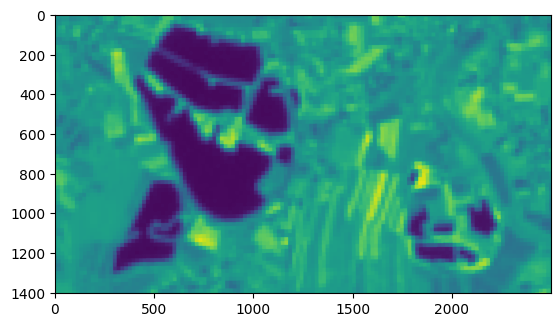

In [9]:
image_band_swir_20m = band_swir_20m.read(1)
if SHOW_IMAGES:
    plt.imshow(image_band_swir_20m)

### Water masks calculation

#### NDWI calculation

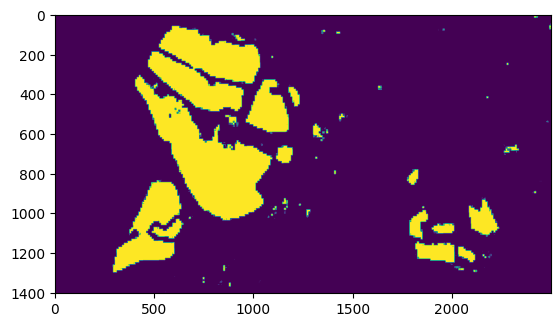

In [10]:
image_band_green_10m_norm = image_band_green_10m / np.max(np.abs(image_band_green_10m))
image_band_nir_10m_norm = image_band_nir_10m / np.max(np.abs(image_band_nir_10m))

image_ndwi = (image_band_green_10m_norm - image_band_nir_10m_norm) // (image_band_green_10m_norm + image_band_nir_10m_norm + np.ones((image_band_green_10m_norm.shape[0], image_band_green_10m_norm.shape[1]))) + np.ones((image_band_green_10m_norm.shape[0], image_band_green_10m_norm.shape[1]))

if SHOW_IMAGES:
    plt.imshow(image_ndwi.astype('uint16'))

#### MNDWI calculation

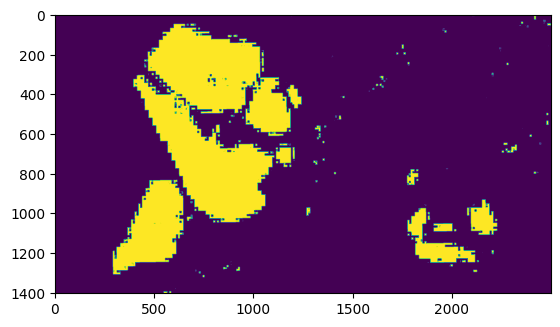

In [11]:
image_band_green_20m_norm = image_band_green_20m / np.max(np.abs(image_band_green_20m))
image_band_swir_20m_norm = image_band_swir_20m / np.max(np.abs(image_band_swir_20m))

image_mndwi = (image_band_green_20m_norm - image_band_swir_20m_norm) // (image_band_green_20m_norm + image_band_swir_20m_norm + np.ones((image_band_green_20m_norm.shape[0], image_band_green_20m_norm.shape[1]))) + np.ones((image_band_green_20m_norm.shape[0], image_band_green_20m_norm.shape[1]))

if SHOW_IMAGES:
    plt.imshow(image_mndwi.astype('uint16'))

### Comparison of NDWI and MNDWI

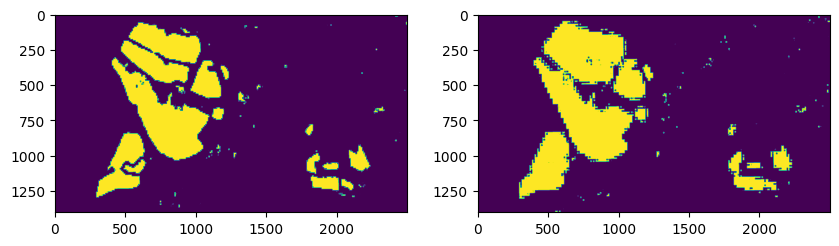

In [12]:
if SHOW_IMAGES:
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].imshow(image_ndwi.astype('uint16'))
    ax[1].imshow(image_mndwi.astype('uint16'))

### Color image show

Please note that this part of the program takes longer to execute. This usually takes a few minutes.

Opening file node2/B02.jpeg
Opening file node2/B03.jpeg
Opening file node2/B04.jpeg
Opening file node2/TRUE_COLOR.jpeg


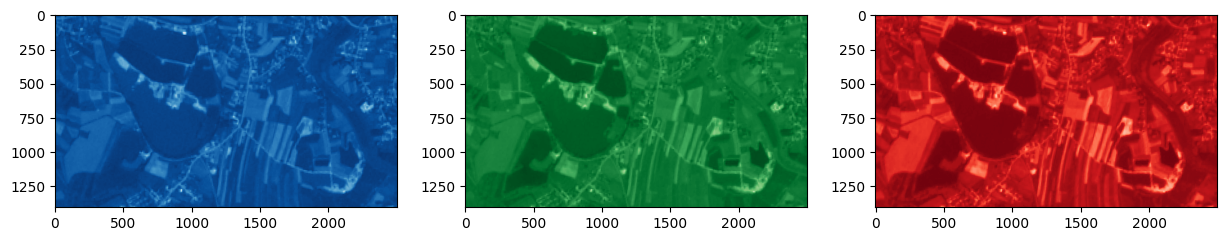

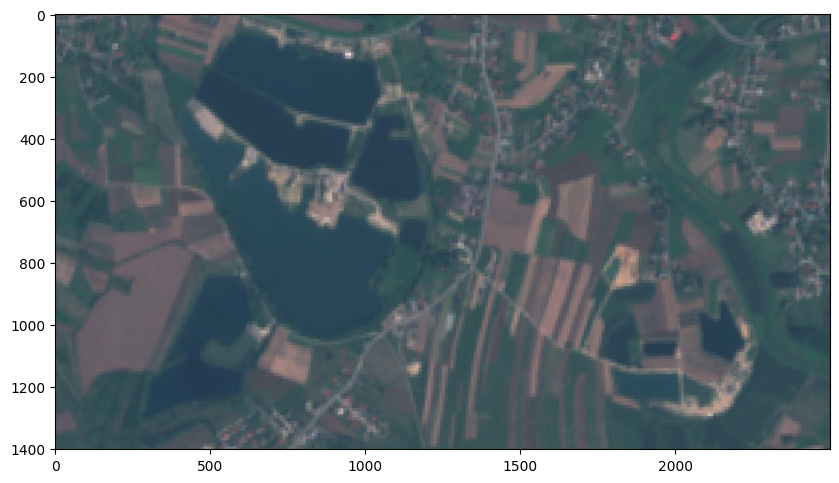

In [13]:
def load_sentinel_image(img_folder, bands):
    image = {}
    for band in bands:
        file = img_folder + band + '.jpeg'
        print(f'Opening file {file}')
        ds = rasterio.open(file)
        image.update({band: ds.read(1)})

    return image

def display_rgb(img, b_r, b_g, b_b, alpha = 1., figsize = (10, 10)):
    rgb = np.stack([img[b_r], img[b_g], img[b_b]], axis = -1)
    rgb = rgb / rgb.max() * alpha
    plt.figure(figsize = figsize)
    plt.imshow(rgb)

img = load_sentinel_image(filepath, ['B02', 'B03', 'B04', 'TRUE_COLOR'])

if SHOW_IMAGES:
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    ax[0].imshow(img['B02'], cmap = 'Blues_r')
    ax[1].imshow(img['B03'], cmap = 'Greens_r')
    ax[2].imshow(img['B04'], cmap = 'Reds_r')

    display_rgb(img, 'B04', 'B03', 'B02', alpha = 1)

# show true color image
#plt.figure(figsize = (10, 10))
#plt.imshow(img['TRUE_COLOR'])

### Mask donwscale

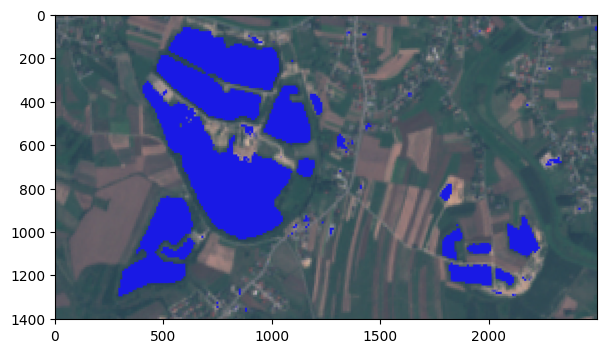

In [14]:
def new_water_mask_downscale(old_mask, old_shape, new_shape):
    new_mask = np.full((new_shape, new_shape), False)
    for i in range(new_shape):
        for j in range(new_shape):
            new_mask[i][j] = old_mask[(old_shape // new_shape) * i][(old_shape // new_shape) * j]
    
    return new_mask

rgb = np.stack([img['B04'], img['B03'], img['B02']], axis = -1)
rgb = rgb / rgb.max() * 1

water_mask = image_ndwi > 0.1

if (water_mask.shape[0] != rgb.shape[0]):
    water_mask = new_water_mask_downscale(water_mask, water_mask.shape[0], rgb.shape[0])

rgb[water_mask] = [0.1, 0.1, 0.9]

if SHOW_IMAGES:
    plt.figure(figsize = (7, 7))
    plt.imshow(rgb)

### Cluster calculation

There are many methods to calculate clusters. The most famous are [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) and [K-Means](https://en.wikipedia.org/wiki/K-means_clustering). The biggest difference is that K-Means is efficient, but it needs an unknown number of clusters to work. For this reason, we decided to use DBSCAN. 

In [29]:
water_indexes = np.transpose(water_mask.nonzero())
clusters = DBSCAN(eps = 5.0, min_samples = 10, algorithm='kd_tree', n_jobs = -1).fit(water_indexes)
# clusters.labels_

### Clusters filter

The program filters only large clusters, ignoring the smaller ones and individual pixels. the `cluster_threshold` variable means the minimum number of points that must be in one cluster for it to be included and shown later. 

In [42]:
#cluster_threshold = 8000
cluster_threshold = 3500
unique, counts = np.unique(clusters.labels_, return_counts = True)
cluster_indexes = dict(zip(unique, counts))
cluster_indexes_above_thre = {k: v for k, v in cluster_indexes.items() if v > cluster_threshold and k != -1}
# cluster_indexes_above_thre

In [43]:
cluster_mask = [idx in cluster_indexes_above_thre for idx in clusters.labels_]
water_indexes_image_coords = water_indexes[cluster_mask]

### Final image with cluster mask 

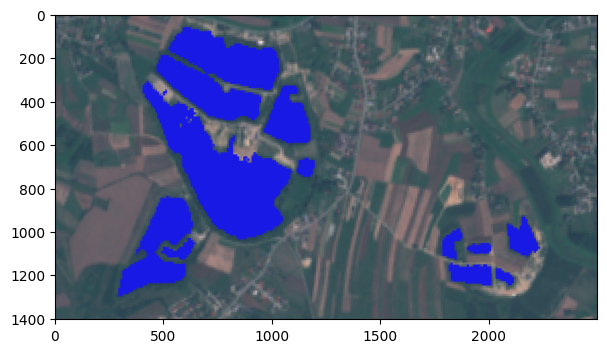

In [44]:
rgb = np.stack([img['B04'], img['B03'], img['B02']], axis=-1)
rgb = rgb/rgb.max() * 1

X = water_indexes_image_coords[:, 0]
Y = water_indexes_image_coords[:, 1]
mask_matrix = np.zeros((rgb.shape[0], rgb.shape[1]), dtype='bool')
mask_matrix[X, Y] = True
mask_matrix
rgb[mask_matrix] = [0.1, 0.1, 0.9]

if SHOW_FINAL_IMAGE:
    plt.figure(figsize = (7,7))
    plt.imshow(rgb)

### Cluster shapes calculation

For the purpose of improving the program's efficiency and run time, the presented shapes are simplified. Point x is the midpoint of the body of water.

In [45]:
data_transform = band_green_10m.transform

move_to_real_coords = lambda water_idx: data_transform * water_idx

zipped_water_clusters = zip(water_indexes, clusters.labels_)
water_cluster_points = {}
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx not in water_cluster_points and cluster_idx in cluster_indexes_above_thre:
        water_cluster_points[cluster_idx] = point

water_indexes_real_coords = np.array([move_to_real_coords(np.array([xi[1], xi[0]])) for xi in water_cluster_points.values()])

In [46]:
cluster_one_points = []

zipped_water_clusters = zip(water_indexes, clusters.labels_)
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx == 0:
        cluster_one_points.append([point[1], point[0]]) 

cluster_one_points = np.array(cluster_one_points)

2
10
11
24
29
31
37
43
44
45
46


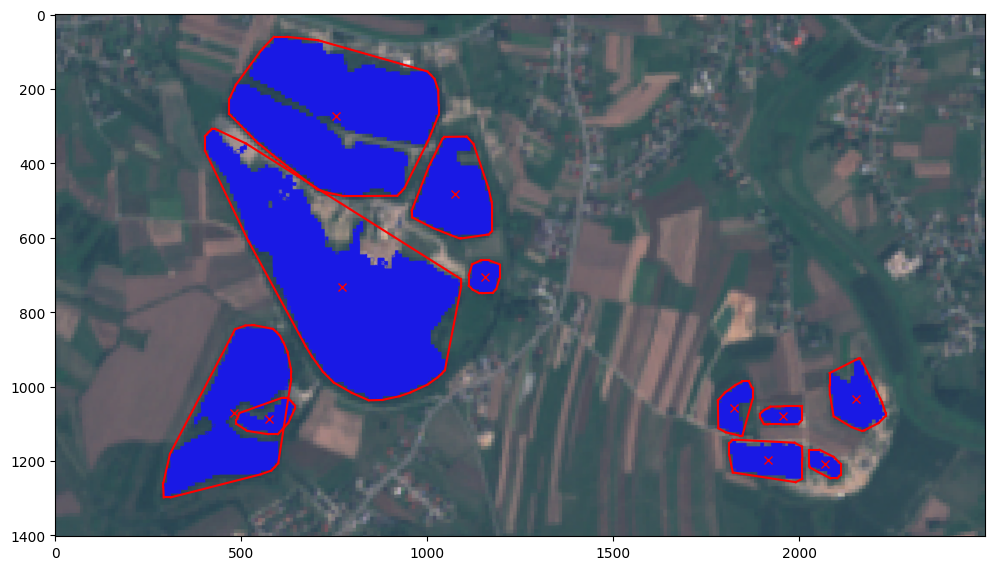

In [47]:
rgb = np.stack([img['B04'], img['B03'], img['B02']], axis=-1)
rgb = rgb/rgb.max() * 1

X = water_indexes_image_coords[:, 0]
Y = water_indexes_image_coords[:, 1]
mask_matrix = np.zeros((rgb.shape[0], rgb.shape[1]), dtype='bool')
mask_matrix[X, Y] = True
rgb[mask_matrix] = [0.1, 0.1, 0.9]

plt.figure(figsize = (12, 12))
plt.imshow(rgb)

for i in cluster_indexes_above_thre:
    print(str(i))
    cluster_one_points = []

    zipped_water_clusters = zip(water_indexes, clusters.labels_)
    for point, cluster_idx in zipped_water_clusters:
        if cluster_idx == i:
            cluster_one_points.append([point[1], point[0]]) 

    cluster_one_points = np.array(cluster_one_points)


    hull = ConvexHull(cluster_one_points)

    cx = np.mean(cluster_one_points[:, 0])
    cy = np.mean(cluster_one_points[:, 1])

    for simplex in hull.simplices:
        plt.plot(cluster_one_points[simplex, 0], cluster_one_points[simplex, 1], 'r-')

    plt.plot(cx, cy, 'rx', ms = 6)

plt.show()